# Idea 
**Client**: Coin Karaoke company (Bubble Karaoke)

Client wants to import coin karaoke booth in Globen.  

> Coin Karaoke means, you can pay by songs not the booked hours.  
For example, pay 10kr to choose 3 songs. You don't have to book, it's a drop in system.  
Very practical and non stressful compare to normal karaoke system.  
Therefore, coin karaoke has already dominated the market in Korea and Japan. 

Bubble Karaoke offers a small booth can only enter 3ppl max.  
Perfect for introverted Swedish people, who want's to enjoy karaoke with their own small bubble.   
So the client think Sweden is the perfect market to start the business.   

**Help them to build a Karaoke song search system and some recommendations from the insights you've gained.**

# Import and Cleaning Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
artists = pd.read_csv('artists.csv', index_col=0)
chart = pd.read_csv('chart.csv', index_col=0)
audio = pd.read_csv('audio.csv', index_col=0)
mapping = pd.read_csv('mapping.csv', index_col=0)
tracks = pd.read_csv('tracks.csv', index_col=0)

In [3]:
artists.drop_duplicates()
chart.drop_duplicates()
audio.drop_duplicates()
mapping.drop_duplicates()
tracks.drop_duplicates()

,track_id,name,duration_ms,release_date,album_type,explicit
0,5CMVGP24paZIukljDj0iWc,Jingle Bells (with The Ken Lane Singers),156666,1945,compilation,False
1,25leEEaz1gIpp7o21Fqyjo,Here Comes Santa Claus (Right Down Santa Claus...,150266,1947,album,False
2,1dtIaSlyrLI04sqYa8nLyN,Rudolph the Red-Nosed Reindeer,186733,1947,album,False
3,4PS1e8f2LvuTFgUs1Cn3ON,The Christmas Song (Merry Christmas To You),192160,1962,album,False
6,5ASM6Qjiav2xPe7gRkQMsQ,Sleigh Ride,181266,1963,compilation,False
...,...,...,...,...,...,...
11065,5sRczgK1xkskY6HICpEKHa,"yes, and? - live version",199448,2024-10-01,album,True
11066,21SiVKUZKwWmL5C64G3R3e,don't wanna break up again,174006,2024-10-01,album,True
11067,4nQLt9m4p0fLUMOogvV6ZN,imperfect for you - live version,186201,2024-10-01,album,True
11068,4M7DbskLseolYL7rooP1SN,My Story,227813,2024-10-04,album,True


In [4]:
audio.dropna(inplace=True)

In [5]:
# chang the data type of tracks name.
artists['name'] = artists['name'].astype(str)
# Filter the name has 'various artist's, 'hit'
dropping_artists = artists[artists['name'].str.contains('various artists|hits', case=False, na=False)]
print(dropping_artists)

                  artist_id                     name  popularity  followers
4    0LyfQWJT6nXafLPZqxe9Of          Various Artists           0    2542450
133  6Xdp9Oz4PJJB9O0yoZmg7r                 BFM Hits          19       1006
185  2XBGYG6QSt4CYiJPPiK9mR    80-90's Top Rock Hits          22       2203
186  7ww48VzAt7aU7xesm7B49B  80's-90's MTV Rock Hits          22       1238
211  6B5GFVu9wzg5rGGjpCCj9s      90's 80's Rock Hits          24       8413


In [6]:
# dropping the cover artists
artists = artists[~artists['name'].str.contains('various artist|hit', case=False, na=False)]

In [7]:
# Process chart data
chart['score'] = round((-15.79 * np.log(chart['list_position'] + 1) + 88.06) * 1.3, 0).astype('int')
chart['chart_year'] = pd.to_datetime(chart['chart_week']).dt.year
chart['chart_month'] = pd.to_datetime(chart['chart_week']).dt.month

In [8]:
# Merge artists on mapping
mapping_artists = pd.merge(mapping, artists, on='artist_id', how='left')

# Merge artist data into track data (left join)
track_map_artists= pd.merge(tracks, mapping_artists, on='track_id', how='left')
track_map_artists.rename(columns={'name_x': 'track_name',
    'name_y': 'artist_name'}, inplace=True)

# Merge charts on top of that
chart_track_artists = pd.merge(chart, track_map_artists, on='track_id', how='left')

# Merge audio and create all 
all = pd.merge(chart_track_artists, audio, on='track_id', how='left')

In [9]:
all.to_csv('all.csv')

# Question1: What makes the song karaoke hits? What is the audio feature formular?

## Step1:Find the mean of the audio features from Karaoke album in all.csv

In [10]:
# Filter Karaoke tracks
karaoke_tracks= all[all['artist_name'].str.contains('karaoke', case=False, na=False)]
# Show only highest scored track among duplicates.
grouped_karaoke = karaoke_tracks.loc[karaoke_tracks.groupby('track_id')['score'].idxmax()]

# Specify the columns for audio features
audio_features_columns = ['instrumentalness', 'acousticness', 'speechiness', 'liveness', 'valence', 'tempo', 'loudness', 'key', 'energy', 'danceability']

# Calculate the mean of the audio features across the grouped karaoke tracks
mean_audio_features = grouped_karaoke[audio_features_columns].mean()

# Print the result
print(mean_audio_features)


instrumentalness      0.298307
acousticness          0.098540
speechiness           0.073669
liveness              0.148138
valence               0.602112
tempo               122.819859
loudness            -10.298471
key                   5.117647
energy                0.555459
danceability          0.706941
dtype: float64


## Step2: And convert the values into percentage

In [11]:
# Normalize function
def normalize(value, min_value, max_value):
    # Apply min-max normalization to scale between 0 and 1
    return (value - min_value) / (max_value - min_value)

# Feature specific ranges (for normalization)
ranges = {
    'instrumentalness': (0, 1),
    'acousticness': (0, 1),
    'speechiness': (0, 1),
    'liveness': (0, 1),
    'valence': (0, 1),
    'tempo': (60, 200),  # Typical tempo range in BPM
    'loudness': (-40, 0),  # Loudness in dB
    'key': (0, 11),  # Musical key scale
    'energy': (0, 1),
    'danceability': (0, 1)
}

# Normalize the mean_audio_features
normalized_features = {}

for mean_audio_features, value in mean_audio_features.items():
    min_value, max_value = ranges[mean_audio_features
]
    normalized_value = normalize(value, min_value, max_value)
    normalized_features[mean_audio_features
] = round(normalized_value * 100)  # Convert to percentage

# Print normalized features
print(normalized_features)


{'instrumentalness': 30, 'acousticness': 10, 'speechiness': 7, 'liveness': 15, 'valence': 60, 'tempo': 45, 'loudness': 74, 'key': 47, 'energy': 56, 'danceability': 71}


## Step3: Make a graph

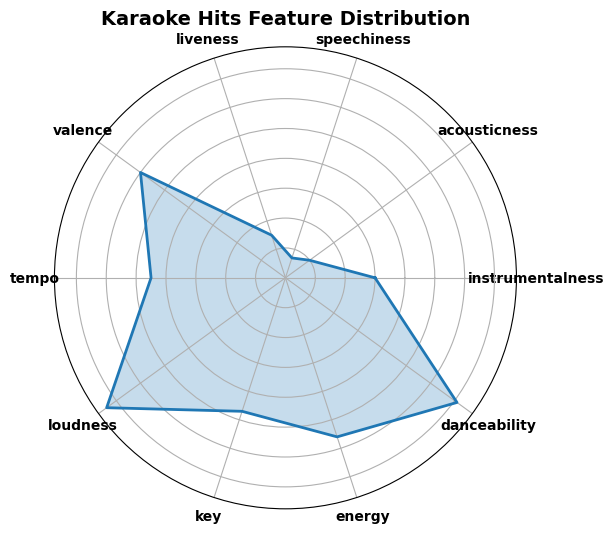

In [12]:
import matplotlib.pyplot as plt


# Feature labels and values (without 'mode')
labels = list(normalized_features.keys())
values = list(normalized_features.values())

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "close" the circle and repeat the first value
values += values[:1]
angles += angles[:1]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot the data
ax.plot(angles, values, linewidth=2, linestyle='solid')

# Fill the area under the plot
ax.fill(angles, values, alpha=0.25)

# Set the labels (features)
ax.set_yticklabels([])  # Hide the radial axis labels
ax.set_xticks(angles[:-1])  # Exclude the last angle which is a duplicate of the first
ax.set_xticklabels(labels, fontsize=10, fontweight='bold')

# Add a title
ax.set_title("Karaoke Hits Feature Distribution", fontsize=14, fontweight='bold')

# Display the plot
plt.show()


## Step4: We need more data. Loaded dataset from Kaggle: Karaoke_hits from spotify

Let's see the audio feature mean of Karaoke hit from kaggle. 

In [13]:
# Let's see the audio feature trend of Karaoke hit from kaggle. 

# Load the dataset (replace 'karaoke_hits_.csv' with your file path)
karaoke_hits_kaggle = pd.read_csv('karaoke_hits_.csv').drop_duplicates()

# Convert column names to lowercase
karaoke_hits_kaggle.columns = karaoke_hits_kaggle.columns.str.lower()

# Change artisti ids into artist_id
karaoke_hits_kaggle = karaoke_hits_kaggle.rename(columns={'artist ids': 'artist_id'})
# Change the column name
karaoke_hits_kaggle = karaoke_hits_kaggle.rename(columns={'track name':'track_name'})

karaoke_hits_kaggle.head(1)


,spotify id,artist_id,track_name,album name,artist name(s),release date,duration (ms),popularity,added by,added at,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time signature
0,68vgtRHr7iZHpzGpon6Jlo,"23zg3TcAtWQy7J6upgbUnj,3DiDSECUqqY1AuBP8qtaIa",My Boo,Confessions (Expanded Edition),"USHER,Alicia Keys",2004-03-23,223440,80,spotify:user:,2024-02-13T21:04:18Z,...,5,-8.238,1,0.118,0.257,0.0,0.0465,0.676,86.412,4


In [14]:
# audio_features_columns = ['instrumentalness', 'acousticness', 'speechiness', 'liveness', 'valence', 'tempo', 'loudness', 'key', 'energy', 'danceability']

# Calculate the mean of the audio features across the grouped karaoke tracks
mean_audio_features_kaggle = karaoke_hits_kaggle[audio_features_columns].mean()

# Print the result
print(mean_audio_features_kaggle)

instrumentalness      0.007428
acousticness          0.190367
speechiness           0.069326
liveness              0.190646
valence               0.622992
tempo               120.605040
loudness             -6.818290
key                   4.540000
energy                0.711890
danceability          0.640910
dtype: float64


In [15]:
# Normalize function
def normalize(value, min_value, max_value):
    # Apply min-max normalization to scale between 0 and 1
    return (value - min_value) / (max_value - min_value)

# Feature specific ranges (for normalization)
ranges = {
    'instrumentalness': (0, 1),
    'acousticness': (0, 1),
    'speechiness': (0, 1),
    'liveness': (0, 1),
    'valence': (0, 1),
    'tempo': (60, 200),  # Typical tempo range in BPM
    'loudness': (-40, 0),  # Loudness in dB
    'key': (0, 11),  # Musical key scale
    'energy': (0, 1),
    'danceability': (0, 1)
}


# Normalize the mean_audio_features
normalized_features = {}

# Iterate through mean_audio_features_kaggle assuming it's a Pandas Series or dict
for mean_audio_feature, value in mean_audio_features_kaggle.items():
    if mean_audio_feature in ranges:  # Check if the feature has a defined range
        min_value, max_value = ranges[mean_audio_feature]
        normalized_value = normalize(value, min_value, max_value)
        normalized_features[mean_audio_feature] = round(normalized_value * 100)  # Convert to percentage

# Print normalized features
print(normalized_features)


{'instrumentalness': 1, 'acousticness': 19, 'speechiness': 7, 'liveness': 19, 'valence': 62, 'tempo': 43, 'loudness': 83, 'key': 41, 'energy': 71, 'danceability': 64}


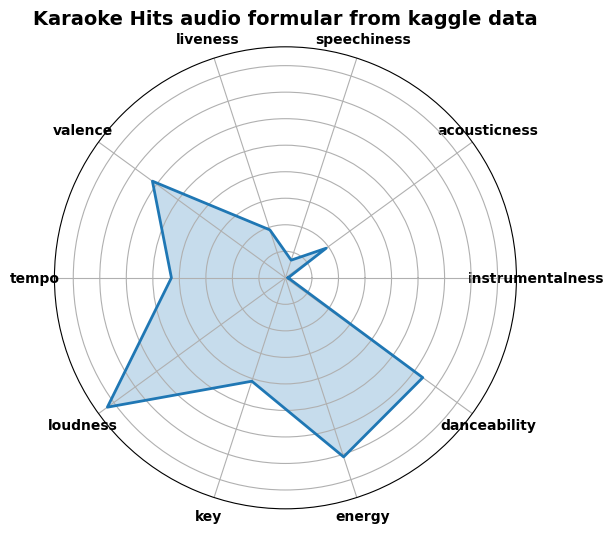

In [16]:
import matplotlib.pyplot as plt


# Feature labels and values (without 'mode')
labels = list(normalized_features.keys())
values = list(normalized_features.values())

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "close" the circle and repeat the first value
values += values[:1]
angles += angles[:1]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot the data
ax.plot(angles, values, linewidth=2, linestyle='solid')

# Fill the area under the plot
ax.fill(angles, values, alpha=0.25)

# Set the labels (features)
ax.set_yticklabels([])  # Hide the radial axis labels
ax.set_xticks(angles[:-1])  # Exclude the last angle which is a duplicate of the first
ax.set_xticklabels(labels, fontsize=10, fontweight='bold')

# Add a title
ax.set_title("Karaoke Hits audio formular from kaggle data", fontsize=14, fontweight='bold')

# Display the plot
plt.show()


# Spotify implimenting for genres

## Data cleaning

I've downloaded from spotify api had too much null values and it was messy. so I will use api downloaded 'artist_genres.csv' I've got from group mates instead. 

In [17]:
artist_genres= pd.read_csv('artist_genres.csv')
artist_genres['genres'].value_counts()
artist_genres['genres'].str

In [18]:
unique_genre_lists = artist_genres['genres'].unique()
unique_genre_lists

array(["['art pop', 'pop']", "['atl trap']", '[]', ...,
       "['pop punk', 'socal pop punk']", "['madchester']",
       "['dirty south rap', 'gangster rap', 'new orleans rap', 'southern hip hop']"],
      dtype=object)

## Getting Unique Genres

In [19]:
import ast
pd.set_option('display.max_rows', None)

# Get unique genres first
unique_genre_lists = artist_genres['genres'].unique()

# Create a set to store all individual genres
all_unique_genres = set()

# Process each unique entry
for genre_list in unique_genre_lists:
    # Convert string representation of list to actual list if needed
    if isinstance(genre_list, str):
        try:
            genres = ast.literal_eval(genre_list)
        except:
            continue
    else:
        genres = genre_list
        
    # Add each genre to our set
    all_unique_genres.update(genres)

# Convert to sorted list if you want alphabetical order
all_unique_genres_list = sorted(list(all_unique_genres))

# Print total count and all genres
print(f"Total unique genres: {len(all_unique_genres_list)}")
print("\nAll genres:")
for genre in all_unique_genres_list:
    print(genre)

Total unique genres: 891

All genres:
5th gen k-pop
8-bit
a cappella
acoustic pop
acoustic rock
adult standards
afro r&b
afrobeats
afrofuturism
afropop
afroswing
alabama indie
alabama metal
alabama rap
alaska indie
alberta country
album rock
albuquerque indie
alt z
alte
alternative americana
alternative country
alternative dance
alternative hip hop
alternative metal
alternative pop
alternative pop rock
alternative r&b
alternative rock
alternative roots rock
ambient folk
american folk revival
american orchestra
anglican liturgy
anime
ann arbor indie
anthem worship
anti-folk
antiviral pop
argentine hip hop
arkansas country
arkansas hip hop
art pop
art punk
art rock
asian american hip hop
athens indie
atl drill
atl hip hop
atl trap
atlanta bass
atlanta punk
aussietronica
australian americana
australian country
australian dance
australian electropop
australian hip hop
australian house
australian indie
australian indie rock
australian pop
australian rock
axe
azonto
azontobeats
bachata
bacha

## Convert them into proper lists

In [20]:
import pandas as pd
import ast

artist_genres = pd.read_csv('artist_genres.csv')

# Print out the first few rows to verify the 'genres' column content
print(artist_genres.head(1))

# Apply the safe_literal_eval function to safely convert string representation of lists into actual lists
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

# Apply the safe_literal_eval to the 'genres' column
artist_genres['genres'] = artist_genres['genres'].apply(safe_literal_eval)

# Verify the transformation
artist_genres.head(1)


                artist_id              genres
0  00FQb4jTyendYWaN8pK0wa  ['art pop', 'pop']


,artist_id,genres
0,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]"


## Map the genres and categorize them

In [21]:
# Define genre categories and their associated keywords (same as before)
genre_categories = {
    "pop": ["pop", "boy band", "girl group", "bubblegum", "bubblegum pop", "dance pop", "pop punk", "pop r&b", "pop rock"],
    "rap/hip-hop": ["hip hop", "rap", "trap", "drill", "gangster rap", "cloud rap", "emo rap", "hardcore hip hop"],
    "rock": ["rock", "indie rock", "classic rock", "punk rock", "alternative rock", "hard rock", "metal", "grunge", "punk"],
    "latin": ["latin", "reggaeton", "bachata", "cumbia", "salsa", "merengue", "mexican pop", "tropical", "latino"],
    "edm": ["edm", "house", "dubstep", "techno", "trance", "electropop", "future bass", "drum and bass"],
    "r&b": ["r&b", "soul", "neo soul", "funk", "r&b en espanol", "classic soul", "contemporary r&b", "modern soul"],
    "country": ["country", "country pop", "country rock", "bluegrass", "americana", "country rap", "outlaw country"],
    "jazz": ["jazz", "smooth jazz", "jazz rap", "jazz guitar", "big band", "bebop", "chamber jazz"],
    "k-pop": ["k-pop", "korean pop", "k-pop boy group", "k-pop girl group"],
    "reggae": ["reggae", "dancehall", "reggae fusion", "roots reggae"],
    "indie": ["indie", "indie pop", "indie rock", "indie folk", "bedroom pop", "lo-fi", "indie soul"],
    "other": []  # Placeholder for genres that don't fit into the above categories
}

# Function to categorize genres
def categorize_genre(genre):
    for category, keywords in genre_categories.items():
        if any(keyword.lower() in genre.lower() for keyword in keywords):
            return category
    return "other"

# Now, let's test the categorization step by applying the categorize_genre function
artist_genres['category'] = artist_genres['genres'].apply(lambda genres: [categorize_genre(genre) for genre in genres])

artist_genres['category'] = artist_genres['category'].apply(lambda categories: categories[0] if categories else 'other')

# Verify the result
artist_genres.head(3)


,artist_id,genres,category
0,00FQb4jTyendYWaN8pK0wa,"[art pop, pop]",pop
1,00UOluVoYY4F2blO5DmgRj,[atl trap],rap/hip-hop
2,010JjFqFcVyJmc2G56puZ2,[],other


In [22]:
# Drop the 'genres' column
artist_genres = artist_genres.drop(columns='genres')

# Rename 'category' column to 'genre'
artist_genres = artist_genres.rename(columns={'category': 'genre'})

# Print the first 3 rows of the DataFrame
artist_genres.head(3)


,artist_id,genre
0,00FQb4jTyendYWaN8pK0wa,pop
1,00UOluVoYY4F2blO5DmgRj,rap/hip-hop
2,010JjFqFcVyJmc2G56puZ2,other


## Merge artist_genres with the all.csv

In [23]:
all_genres = pd.merge(all, artist_genres, on='artist_id', how='inner')

# let's drop cover artists
all_genres = all_genres[~(all_genres['track_name'].str.contains('cover|instrumental|karaoke|version', case=False, na=False) | 
                          all_genres['artist_name'].str.contains('cover|instrumental|karaoke|version|glee', case=False, na=False))]
# Check for missing values in all_genre
all_genres.isnull().sum()

# If necessary, drop rows with missing values
all_genres = all_genres.dropna()  # or use fillna() if you prefer to fill missing values

# Alternatively, check for duplicates
all_genres = all_genres.drop_duplicates()


## Now let's sort the tracks from 'all_genres(merged data)' that has similar audio features to karaoke hits.

You can check the value of similarity to karaoke hits in 'distance to mean' column.
- **Lower number** means the track has **more** similarity with karaoke hits.
- **Higher number** means the track has **less** similarity with karaoke hits. 

In [24]:
import numpy as np

# Define the audio features columns (already defined in your setup)
#audio_features_columns = [
#    'instrumentalness', 'acousticness', 'speechiness', 
#    'liveness', 'valence', 'tempo', 'loudness', 
#    'key', 'energy', 'danceability'
#]

# Calculate the mean audio features for karaoke hits (from karaoke_friendly_tracks or a provided dataset)
#mean_audio_features_kaggle = karaoke_friendly_tracks[audio_features_columns].mean()

# Group by 'track_name' and find the row with the highest 'score'
highscored_track = all_genres.loc[all_genres.groupby('track_name')['score'].idxmax()]

# Compute the Euclidean distance for each track in the grouped dataset
highscored_track['distance_to_mean'] = highscored_track[audio_features_columns].apply(
    lambda row: np.linalg.norm(row - mean_audio_features_kaggle), axis=1
)

# Sort by 'score' (descending), 'distance_to_mean' (ascending), and 'popularity' (descending)
karaoke_friendly_tracks= highscored_track.sort_values(['score', 'distance_to_mean', 'popularity'], ascending=[False, True, False])

# Filter by distance_to_mean ≤ 20
karaoke_friendly_tracks_filtered = karaoke_friendly_tracks[karaoke_friendly_tracks['distance_to_mean'] <= 20]

# Display the top 10 filtered karaoke-friendly tracks
karaoke_friendly_tracks_filtered[['track_name', 'artist_name', 'distance_to_mean', 'score', 'popularity', 'genre']].head(10)


,track_name,artist_name,distance_to_mean,score,popularity,genre
14902,This Is America,Childish Gambino,1.064613,100,81.0,rap/hip-hop
70495,Wrecking Ball,Miley Cyrus,1.076390,100,84.0,pop
83538,Call Me Maybe,Carly Rae Jepsen,2.558156,100,73.0,pop
128635,Poker Face,Lady Gaga,2.791363,100,92.0,pop
84314,Like Crazy,Jimin,2.904285,100,89.0,pop
53179,Music,Madonna,3.107844,100,81.0,pop
19871,Blurred Lines,Robin Thicke,3.291559,100,64.0,pop
40514,Raise Your Glass,P!nk,3.376331,100,82.0,pop
187918,Burn,USHER,3.634877,100,83.0,rap/hip-hop
83973,All of Me,John Legend,3.655352,100,77.0,r&b


## Manipulate noticable error

In [25]:
# manipulate error
# Update the genre for Jimin & USHER's songs
karaoke_friendly_tracks_filtered.loc[karaoke_friendly_tracks_filtered['artist_name'] == 'Jimin', 'genre'] = 'k-pop'
karaoke_friendly_tracks_filtered.loc[karaoke_friendly_tracks_filtered['artist_name'] == 'USHER', 'genre'] = 'r&b'


In [26]:
# Display the top similar tracks
karaoke_friendly_tracks_filtered[['track_name', 'artist_name', 'distance_to_mean', 'score', 'genre']].head(10)

,track_name,artist_name,distance_to_mean,score,genre
14902,This Is America,Childish Gambino,1.064613,100,rap/hip-hop
70495,Wrecking Ball,Miley Cyrus,1.076390,100,pop
83538,Call Me Maybe,Carly Rae Jepsen,2.558156,100,pop
128635,Poker Face,Lady Gaga,2.791363,100,pop
84314,Like Crazy,Jimin,2.904285,100,k-pop
53179,Music,Madonna,3.107844,100,pop
19871,Blurred Lines,Robin Thicke,3.291559,100,pop
40514,Raise Your Glass,P!nk,3.376331,100,pop
187918,Burn,USHER,3.634877,100,r&b
83973,All of Me,John Legend,3.655352,100,r&b


In [27]:
# Save the DataFrame to a CSV file
karaoke_friendly_tracks_filtered.to_csv('karaoke_friendly_tracks_filtered.csv', index=False)

In [28]:
# Load the CSV back into a DataFrame
karaoke_friendly_tracks_filtered = pd.read_csv('karaoke_friendly_tracks_filtered.csv')

# Question2: Can we have karaoke track search functions ?

## Mini Question1: Top 10 Tracks by artists

In [42]:
from tabulate import tabulate

# Input artist name to search
input_artist = input("Enter the artist name: ")  # User can type any artist name

# Filter karaoke_friendly_tracks by the artist name
artist_songs = karaoke_friendly_tracks_filtered.loc[karaoke_friendly_tracks_filtered['artist_name'].str.contains(input_artist, case=False, na=False)]

# Display the top 10 songs sorted by 'score' and then by 'distance_to_mean'
if not artist_songs.empty:
    # First, get the top 20 songs based on 'score'
    top_20_songs = artist_songs.head(10)
    print(tabulate(top_20_songs[['track_name', 'artist_name', 'genre','distance_to_mean']], headers='keys', tablefmt='pretty', showindex=False))

else:
    print(f"No songs found for artist: {input_artist}")


+--------------------------------------------------------------------------------------------+-------------+-------+--------------------+
|                                         track_name                                         | artist_name | genre |  distance_to_mean  |
+--------------------------------------------------------------------------------------------+-------------+-------+--------------------+
|                                        Don't Matter                                        |    Akon     |  pop  | 7.2377030679003145 |
|                                   Bartender (feat. Akon)                                   |    Akon     |  pop  | 22.959661549898822 |
|                                    Right Now (Na Na Na)                                    |    Akon     |  pop  | 21.617526240174556 |
|                                        What You Got                                        |    Akon     |  pop  | 7.247348698899576  |
|                                 

## Mini Question2: Can I search by title?

In [30]:
from tabulate import tabulate

# Mapping numerical values to musical keys
key_mapping = {
    0.0: 'C', 1.0: 'C# / Db', 2.0: 'D', 3.0: 'D# / Eb', 4.0: 'E',
    5.0: 'F', 6.0: 'F# / Gb', 7.0: 'G', 8.0: 'G# / Ab', 9.0: 'A',
    10.0: 'A# / Bb', 11.0: 'B'
}

# Input track name to search
input_track = input("Search by Track Name: ").lower()  # Convert to lowercase for case-insensitive search

# Filter karaoke_friendly_tracks by track name (case-insensitive)
# I'm using 'karaoke_friendly_tracks' istead of 'karaoke_friendly_tracks_filtered' because it needs to show more results for user experience.
filtered_tracks = karaoke_friendly_tracks[
    karaoke_friendly_tracks['track_name'].str.contains(input_track, case=False, na=False)
]

# If the filtered tracks are not empty, proceed to replace the 'key' values
if not filtered_tracks.empty:
    # Use .loc to set the 'key' values properly
    filtered_tracks.loc[:, 'key'] = filtered_tracks['key'].map(key_mapping).fillna(filtered_tracks['key'])

    # Format the output as a nice table using tabulate
    print(tabulate(filtered_tracks[['track_name', 'artist_name', 'genre', 'key']], headers='keys', tablefmt='pretty', showindex=False))
else:
    print(f"No tracks found for '{input_track}'.")

+-----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------------+---------+
|                                                                  track_name                                                                   |            artist_name             |    genre    |   key   |
+-----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------------+---------+
|                                                   we can't be friends (wait for your love)                                                    |           Ariana Grande            |     pop     |    F    |
|                                                                 We Found Love                                                                 |              Rihanna      

C:\Users\desig\AppData\Local\Temp\ipykernel_25544\3028030788.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['F' 'C# / Db' 'C# / Db' 'F' 'E' 'C' 'E' 'C' 'D' 'G' 'B' 'C' 'A' 'F' 'A'
 'G# / Ab' 'C# / Db' 'D' 'E' 'A# / Bb' 'E' 'G# / Ab' 'G' 'D' 'C# / Db' 'D'
 'D' 'G# / Ab' 'C' 'F# / Gb' 'C' 'B' 'F# / Gb' 'F' 'B' 'E' 'F' 'D' 'D' 'C'
 'C' 'G# / Ab' 'C# / Db' 'G# / Ab' 'E' 'A' 'C# / Db' 'F' 'F# / Gb' 'G' 'B'
 'F' 'F# / Gb' 'C# / Db' 'A# / Bb' 'C# / Db' 'A# / Bb' 'D' 'D' 'G' 'E'
 'F# / Gb' 'A# / Bb' 'E' 'G# / Ab' 'A' 'D' 'G# / Ab' 'F' 'C' 'E' 'C# / Db'
 'F' 'G# / Ab' 'C' 'G' 'B' 'C# / Db' 'B' 'G' 'G# / Ab' 'F' 'E' 'C# / Db'
 'G# / Ab' 'A' 'C# / Db' 'F' 'F# / Gb' 'F' 'C' 'G# / Ab' 'A' 'C# / Db' 'A'
 'C# / Db' 'C' 'A# / Bb' 'F' 'D# / Eb' 'G# / Ab' 'B' 'B' 'C# / Db'
 'F# / Gb' 'D' 'F# / Gb' 'E' 'G' 'A' 'D# / Eb' 'G# / Ab' 'D' 'A' 'G# / Ab'
 'B' 'B' 'A' 'G' 'A' 'E' 'A# / Bb' 'G' 'G' 'C' 'A' 'D' 'C' 'D' 'G# / Ab'
 'A' 'C

## Mini Question3: Top 10 Tracks by Genre

In [31]:
import re
from tabulate import tabulate

# Input genre to search
input_genre = input("Search by Genre: ").lower()  # Convert user input to lowercase for case-insensitive comparison

# Create a regex pattern with word boundaries to avoid matching substrings like "k-pop" when searching "pop"
pattern = r'\b' + re.escape(input_genre) + r'\b'

# Filter karaoke_friendly_tracks by the genre using regex (allow partial matches but avoid incorrect matches like k-pop)
filtered_genre = karaoke_friendly_tracks_filtered[karaoke_friendly_tracks_filtered['genre'].str.contains(pattern, case=False, na=False, regex=True)]

# Explicitly filter out "k-pop" if the input genre is "pop"
if input_genre == 'pop':
    filtered_genre = filtered_genre[~filtered_genre['genre'].str.contains('k-pop', case=False, na=False)]

# Display the top 10 songs
if not filtered_genre.empty:
    # Get the top 20 songs
    top_20_genres = filtered_genre.head(10)
    
    # Display results in a table
    print(tabulate(top_20_genres[['track_name', 'artist_name', 'genre', 'distance_to_mean']], headers='keys', tablefmt='pretty', showindex=False))
else:
    print(f"No songs found for genre: {input_genre}")


+----------------------------+-------------------+-------+--------------------+
|         track_name         |    artist_name    | genre |  distance_to_mean  |
+----------------------------+-------------------+-------+--------------------+
|       Wrecking Ball        |    Miley Cyrus    |  pop  | 1.0763899611403405 |
|       Call Me Maybe        | Carly Rae Jepsen  |  pop  | 2.558156442365991  |
|         Poker Face         |     Lady Gaga     |  pop  | 2.7913625902227976 |
|           Music            |      Madonna      |  pop  | 3.107844432177495  |
|       Blurred Lines        |   Robin Thicke    |  pop  | 3.291558937182712  |
|      Raise Your Glass      |       P!nk        |  pop  | 3.376330555310576  |
|       We R Who We R        |       Kesha       |  pop  | 4.017506691580249  |
|        Be With You         | Enrique Iglesias  |  pop  | 4.056298851647065  |
|         Just Dance         |     Lady Gaga     |  pop  | 4.516958304623257  |
| SexyBack (feat. Timbaland) | Justin Ti

## Mini Question3: Top 10 Tracks by Year (chart year)

In [38]:
# Input year to search
input_year = input("Search by Year: ")

# Filter karaoke_friendly_tracks by the year
filtered_year = karaoke_friendly_tracks_filtered.loc[karaoke_friendly_tracks_filtered['chart_year'].astype(str).str.contains(input_year, case=False, na=False)]

# Display the top 10 songs
if not filtered_year.empty:
    # Get the top 20 songs
    top_20_year = filtered_year.head(10)
    
    # Format the output as a nice table using tabulate
    print(tabulate(top_20_year[['track_name', 'artist_name', 'genre', 'chart_year', 'distance_to_mean']], headers='keys', tablefmt='pretty', showindex=False))
else:
    print(f"No songs found for year: {input_year}")


+-------------------------------------------------------------+-----------------+-------+------------+--------------------+
|                         track_name                          |   artist_name   | genre | chart_year |  distance_to_mean  |
+-------------------------------------------------------------+-----------------+-------+------------+--------------------+
|                        Hot In Herre                         |      Nelly      |  pop  |    2002    | 23.064756268001528 |
|                           Gangsta                           |      Tems       |  r&b  |    2002    | 18.884206196116867 |
|                         In the End                          |   Linkin Park   | rock  |    2002    | 19.86345574671137  |
|                           Work It                           |  Missy Elliott  |  pop  |    2002    | 25.427499091006844 |
|                      Underneath It All                      |    No Doubt     |  pop  |    2002    | 19.41823331415634  |
|       

## Mini Question4: Top 10 2024 Tracks by Month.

In [33]:
from tabulate import tabulate

# Input month to search (from 1 to 12)
input_month = input("Search by Month (1-12) of 2024: ")

# Filter karaoke_friendly_tracks by the year (2024) and exact month match
filtered_month = karaoke_friendly_tracks_filtered[
    (karaoke_friendly_tracks_filtered['chart_year'] == 2024) &
    (karaoke_friendly_tracks_filtered['chart_month'].astype(str) == input_month)  # Directly compare the month
]

# Display the top 20 songs
if not filtered_month.empty:
    # Get the top 10 songs
    top_20_month = filtered_month.head(10)
    
    # Format the output as a nice table using tabulate
    print(tabulate(top_20_month[['track_name', 'artist_name', 'genre', 'chart_year', 'chart_month']], headers='keys', tablefmt='pretty', showindex=False))
else:
    print(f"No songs found for month {input_month} in 2024.")


+----------------------------------------+----------------+-------------+------------+-------------+
|               track_name               |  artist_name   |    genre    | chart_year | chart_month |
+----------------------------------------+----------------+-------------+------------+-------------+
|                 greedy                 |   Tate McRae   |     pop     |    2024    |      1      |
|                 Water                  |      Tyla      |    other    |    2024    |      1      |
| Let It Snow! Let It Snow! Let It Snow! |  Dean Martin   |    other    |    2024    |      1      |
|             Lil Boo Thang              |  Paul Russell  |     r&b     |    2024    |      1      |
|                n.h.i.e.                |   21 Savage    | rap/hip-hop |    2024    |      1      |
|     Little Saint Nick - 1991 Remix     | The Beach Boys |     pop     |    2024    |      1      |
|              pop ur shit               |  Metro Boomin  | rap/hip-hop |    2024    |     

# Question3: Which Artist is the Karaoke Hit maker?

In [34]:
# Assuming 'karaoke_friendly_tracks' is your DataFrame with the audio features
# List of audio features columns
#audio_features_columns = [
#    'instrumentalness', 'acousticness', 'speechiness', 
#    'liveness', 'valence', 'tempo', 'loudness', 
#    'key', 'energy', 'danceability'
#]

# Calculate the mean of the audio features across all tracks
mean_audio_features = karaoke_friendly_tracks_filtered[audio_features_columns].mean()

# Calculate the distance to the mean for each track by summing the absolute differences of each feature
karaoke_friendly_tracks_filtered['distance_to_mean'] = karaoke_friendly_tracks_filtered[audio_features_columns].apply(
    lambda row: ((row - mean_audio_features).abs()).sum(), axis=1
)

# Define a threshold for "close" to the mean (e.g., within 10% of the mean)
threshold = mean_audio_features.sum() * 0.1  # 10% threshold (you can adjust this value)

# Filter the tracks that are close to the mean based on the distance
close_tracks = karaoke_friendly_tracks_filtered[karaoke_friendly_tracks_filtered['distance_to_mean'] <= threshold]

# Count how many tracks each artist has that are close to the mean
artist_counts = close_tracks['artist_name'].value_counts()

# Find the artist with the most tracks close to the mean
most_tracks_artist = artist_counts.idxmax()
most_tracks_count = artist_counts.max()

print(f"**{most_tracks_artist}** is the Karaoke Hit maker, who made **{most_tracks_count}** Hit tracks.")


**Drake** is the Karaoke Hit maker, who made **21** Hit tracks.


# Question4: Comparing the difference of audio features between Karaoke hits and Popular tracks.

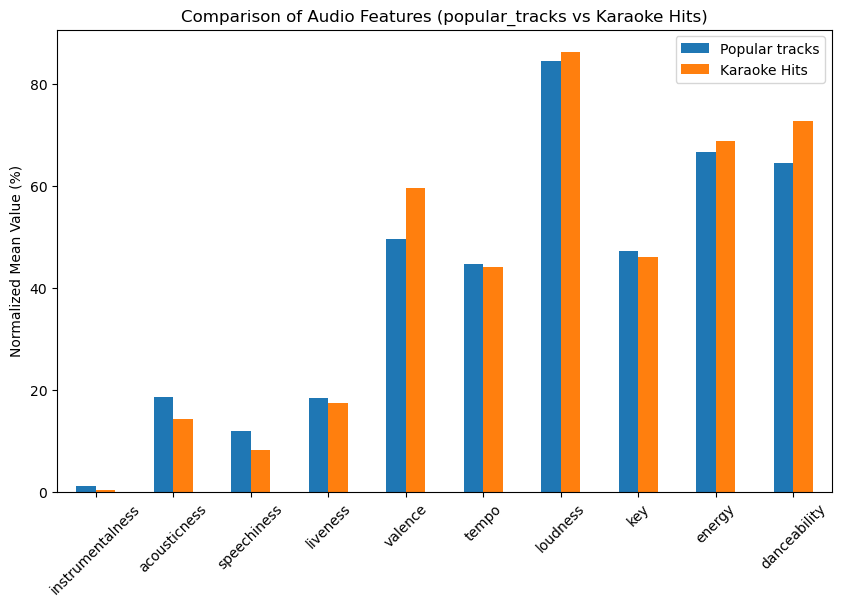

In [35]:
# Select top popular songs and karaoke-friendly tracks
# Find the row with the minimum 'list_position' for each 'track_name'
top_tracks = highscored_track.loc[highscored_track.groupby('track_name')['list_position'].idxmin()]
top_karaoke_hits = karaoke_friendly_tracks_filtered.head(100)

# Calculate mean audio features
top_tracks_means = top_tracks[audio_features_columns].mean()
karaoke_hits_means = top_karaoke_hits[audio_features_columns].mean()

# Normalize the mean audio features
normalized_top_tracks_means = {}
normalized_karaoke_hits_means = {}

for feature in audio_features_columns:
    if feature in ranges:  # Check if the feature has a defined range
        min_value, max_value = ranges[feature]
        
        # Normalize popular songs mean
        normalized_top_tracks_means[feature] = normalize(top_tracks_means[feature], min_value, max_value) * 100
        
        # Normalize karaoke hits mean
        normalized_karaoke_hits_means[feature] = normalize(karaoke_hits_means[feature], min_value, max_value) * 100

# Create a DataFrame for the normalized means
comparison_df = pd.DataFrame({
    'Popular tracks': normalized_top_tracks_means,
    'Karaoke Hits': normalized_karaoke_hits_means
})

# Plot the comparison
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Audio Features (popular_tracks vs Karaoke Hits)')
plt.ylabel('Normalized Mean Value (%)')
plt.xticks(rotation=45)
plt.show()


# Question5: What is popular genre in Karaoke Hits?

In [36]:
# Count the number of tracks by genre
genre_counts = karaoke_friendly_tracks_filtered['genre'].value_counts()

In [37]:
# Convert to a DataFrame for better visualization
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Genre', 'Count']

# Print the table
print(tabulate(genre_counts_df, headers='keys', tablefmt='pretty', showindex=False))


+-------------+-------+
|    Genre    | Count |
+-------------+-------+
|     pop     | 1249  |
| rap/hip-hop | 1017  |
|   country   |  602  |
|    other    |  464  |
|    rock     |  258  |
|     r&b     |  242  |
|    latin    |  54   |
|    indie    |  30   |
|     edm     |  26   |
|   reggae    |   7   |
|    k-pop    |   3   |
|    jazz     |   1   |
+-------------+-------+


# Conclusion of Insights

- Insight 1: Karaoke hits tend to prioritize higher valence, danceability, energy, and loudness compared to popular tracks.
  Karaoke hits are lower in acousticness and speechiness than the popular tracks. 
  These characteristics make songs more engaging and suitable for group participation and enjoyment during karaoke sessions.
- Insight 2: Drake is the Karaoke Hit maker, by having 21 hit tracks. 
- Insight 3: Popular genre for karaoke is pop > rap/hiphop > country > rock > r&b ...

# Note for client 'Bubble Karaoke'

To Bubble Karaoke:
- Download hit music that has high is valance, danceability, energy, loudness, but lower in acousticness, speechiness in the Karaoke program. 
- Download lots of Drake hit songs in the Karaoke program. 
- Popular genre order is Pop > Rap/Hiphop > Country > Rock > R&B...etc. so make a genre search 'drop down' orders accordingly. 